In [3]:
import pandas as pd
from pathlib import Path

In [10]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Sp/Imagenes_confocal/sp_para entrenar/'
pathlist = Path(path).glob('*.csv')
sparks_data_list = []
for file in pathlist:
    path_in_str = str(file)
    df = pd.read_csv(path_in_str)
    sparks_data_list.append(df)
sparks_data_list = pd.concat(sparks_data_list)
del (sparks_data_list['Unnamed: 0'])
del (sparks_data_list['minim'])
del (sparks_data_list['FWHM'])
del (sparks_data_list['pos_x'])
del (sparks_data_list['pos_y'])
del (sparks_data_list['FDHM'])
del (sparks_data_list['full_width'])
del (sparks_data_list['sparks_tiempo_pico50_2'])
del (sparks_data_list['tiempo_minimo'])

In [11]:
sparks_data_list.to_csv(path + 'sparks_data_list.csv')

In [12]:
#Disabling the warnings permantently
import warnings
warnings.filterwarnings('ignore')

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


from sklearn.model_selection import (RandomizedSearchCV,
                                     KFold,
                                     cross_val_score,
                                     train_test_split)
from sklearn.metrics import (roc_auc_score,
                             make_scorer,
                             classification_report,
                             roc_curve,
                             f1_score,
                             matthews_corrcoef,
                             precision_score,
                             recall_score,
                             confusion_matrix)

from xgboost import XGBClassifier

In [14]:
sparks_data_list.isnull().sum()

tiempo_maximo            61
intensidad_maxima        61
intensidad_minima        61
tiempo_valle             61
intensidad_valle         61
sparks_amplitud          61
TTP                      61
sparks_tiempo_pico50     61
sp_tau                  328
TTP50                    61
fullWidth                61
(ΔF/F0)/ΔTmax            61
fullDuration             61
width                     0
high                      0
flag                      0
dtype: int64

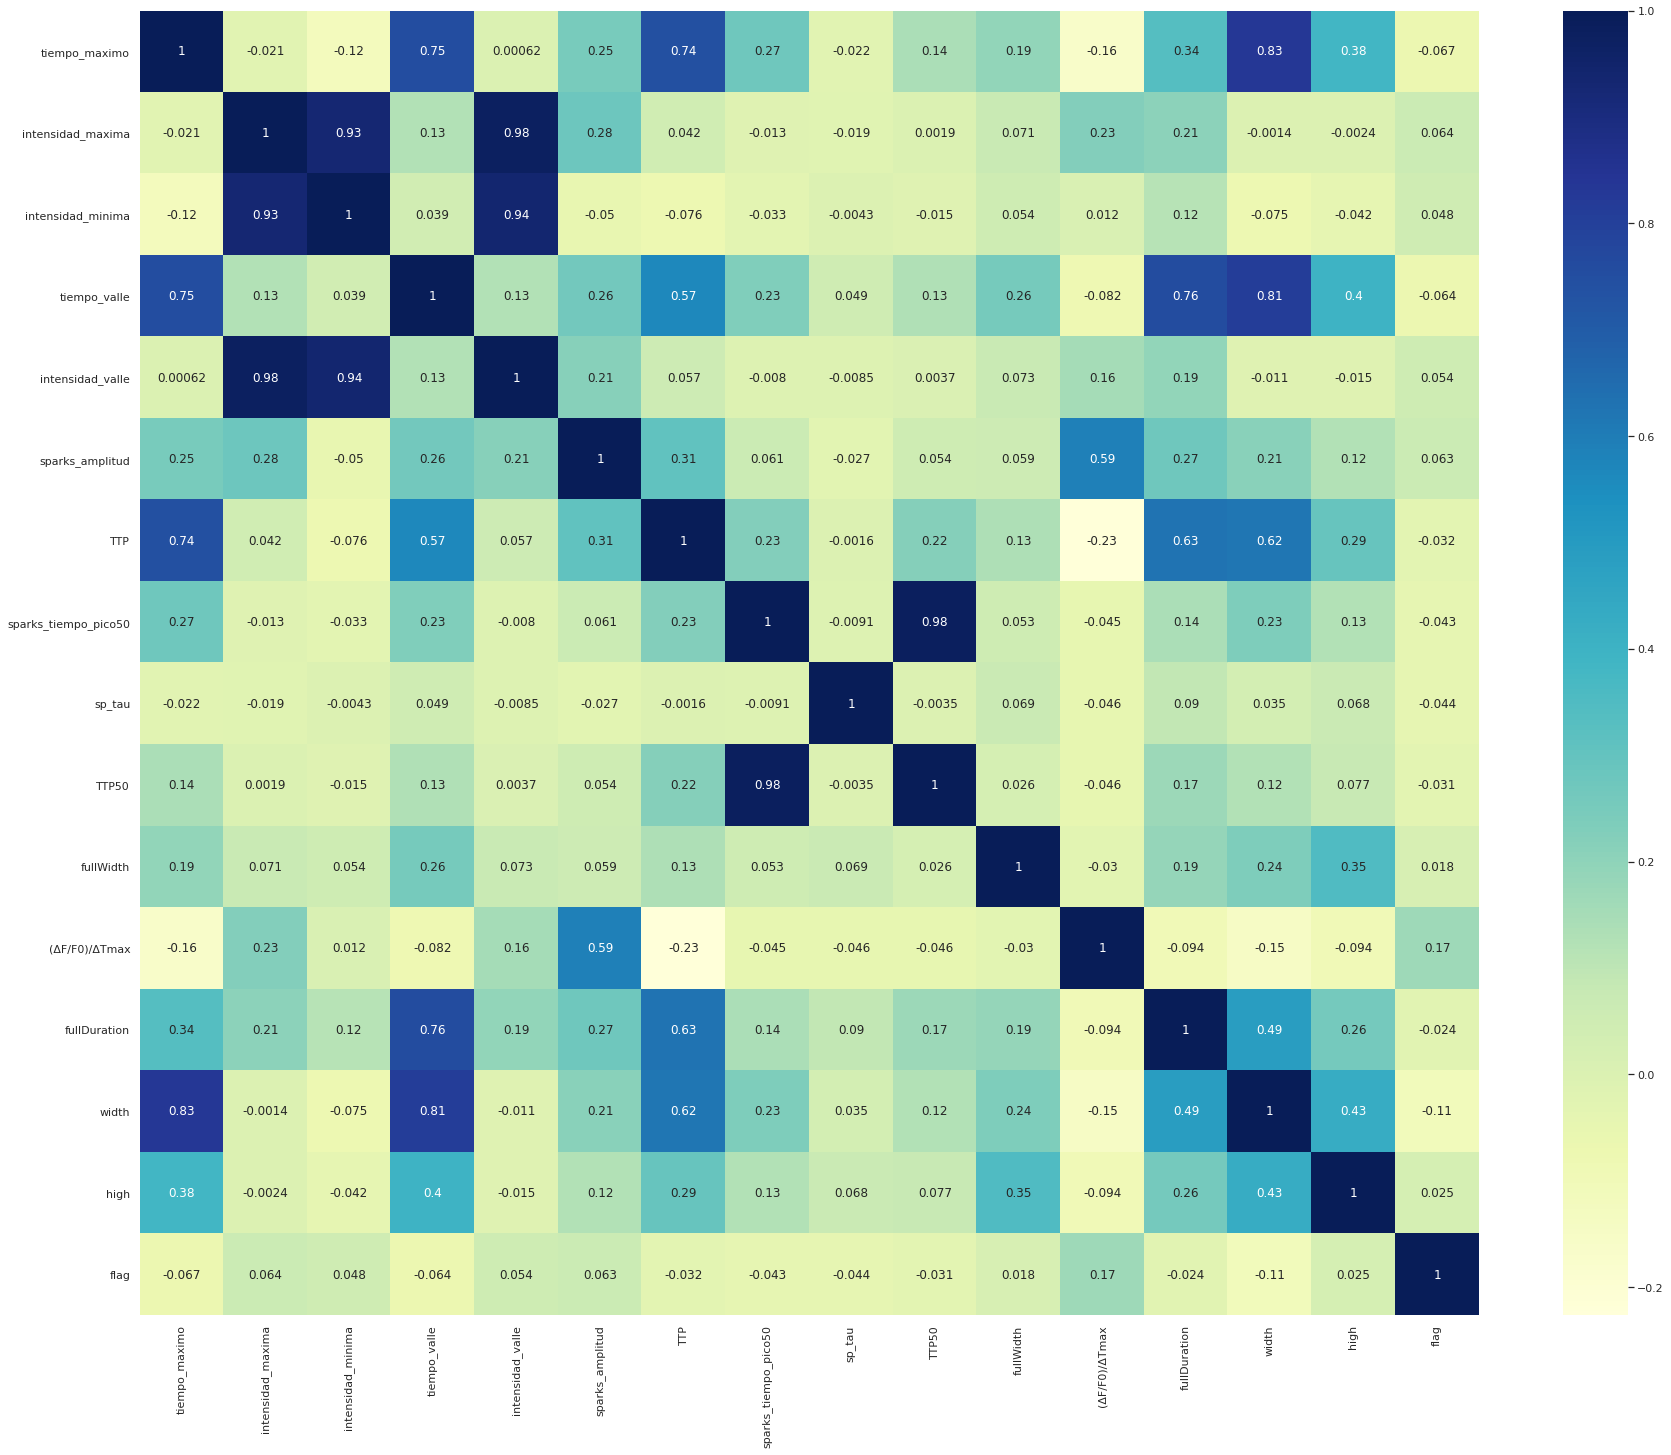

In [15]:
corr = sparks_data_list[sparks_data_list.columns].corr()
sns.heatmap(corr, cmap="YlGnBu", annot = True)
sns.set(rc={'figure.figsize':(30,24)})

In [16]:
X = sparks_data_list.drop(['flag'], axis=1).values
y = sparks_data_list.flag

In [17]:
X_train,X_test,  y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y)

In [44]:
df_train = pd.DataFrame(y_train)
df_test = pd.DataFrame(y_test)

In [46]:
print(df_train.groupby('flag').size())
print(df_test.groupby('flag').size())

flag
1.0    779
2.0    898
dtype: int64
flag
1.0    334
2.0    386
dtype: int64


In [20]:
from sklearn.impute import SimpleImputer

# Tratamiento de NaN
imp = SimpleImputer(missing_values=np.nan, strategy='median') # Uso el promedio para reemplazar
imp.fit(X_train)
X_train = imp.transform(X_train)

imp.fit(X_test)
X_test = imp.transform(X_test)

In [21]:
model_baseline = XGBClassifier()

In [22]:
model_baseline.fit(X_train, y_train)

[08:23:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
def get_prediction(predictions):
    new_preds = []
    for preds in predictions:
        if preds >= 0.25:
            new_preds.append(1)
        else: new_preds.append(2)
    return new_preds

In [24]:
pred_proba_train = model_baseline.predict_proba(X_train)[:, 1]
pred_proba_test = model_baseline.predict_proba(X_test)[:, 1]

pred_train = get_prediction(pred_proba_train)
pred_test = get_prediction(pred_proba_test)

In [25]:
print(f"Train ROC-AUC: {np.round(roc_auc_score(y_train, pred_proba_train), 2)}")
print(f"Test ROC-AUC: {np.round(roc_auc_score(y_test, pred_proba_test), 2)}")

Train ROC-AUC: 1.0
Test ROC-AUC: 0.7
